# Quantium Virtual Internship.
## Retain Strategy and Analytics - Task 2.

# Table of Contents.
* [Libraries](#sec_1)
* [Functions](#sec_2)
* [Data Wrangling](#sec_3)
    * [Date](#sec_3.1)
* [Correlation Evaluation](#sec_4)
    * [Total Sales](#sec_4.1)
    * [Number of Customers](#sec_4.2)
    * [Scores](#sec_4.3)
        * [Total Sales Score](#sec_4.3.1)
        * [Number of Customers Score](#sec_4.3.2)
    * [Visualisations](#sec_4.4)
* [Trial Assessments.](#sec_5)
    * [Trial Store 77](#sec_5.1)
        * [Total Sales](#sec_5.1.1)
        * [Number of Customers](#sec_5.1.2)
    * [Trial Store 86](#sec_5.2)
        * [Total Sales](#sec_5.2.1)
        * [Number of Customers](#sec_5.2.2)
    * [Trial Store 88](#sec_5.3)
        * [Total Sales](#sec_5.3.1)
        * [Number of Customers](#sec_5.3.2)

# Libraries. <a class="anchor" id="sec_1"></a>

In [1]:
import pandas as pd
import numpy as np
import statistics as st
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain
from datetime import datetime as dt
from scipy.stats import pearsonr, t

# Functions. <a class="anchor" id="sec_2"></a>

In [2]:
def Metrics(df):

    # Grouping the df to find the total sales for each store by yearmonth.
    metricsDF = pd.DataFrame(df.groupby(['STORE_NBR',
                                            'YEARMONTH'])['TOT_SALES'].sum()\
                            .reset_index(name = 'totSales'))

    # Grouping the df to find the total customers for each store by yearmonth.
    nCustomers = pd.DataFrame(df.groupby(['STORE_NBR',
                                          'YEARMONTH'])['LYLTY_CARD_NBR'].nunique()\
                              .reset_index(name = 'nCustomers'))['nCustomers']

    # Grouping the df to find the total unique transactions for each store by yearmonth.
    nTxnPerCust = pd.DataFrame(df.groupby(['STORE_NBR',
                                           'YEARMONTH',
                                           'LYLTY_CARD_NBR'],
                                          as_index = False)[['LYLTY_CARD_NBR', 'TXN_ID']].nunique()\
                               .groupby(['STORE_NBR',
                                         'YEARMONTH'])['TXN_ID'].mean()\
                               .reset_index(name = 'nTxnPerCust')
                              )['nTxnPerCust']
    
    # Grouping the df to find the mean number of chips purchased per transaction for each store
    # by yearmonth.
    nChipsPerTxn = pd.DataFrame(df.groupby(['STORE_NBR',
                                            'YEARMONTH',
                                            'TXN_ID'],
                                           as_index = False)['PROD_QTY'].sum()\
                                .groupby(['STORE_NBR', 'YEARMONTH'])['PROD_QTY'].mean()\
                                .reset_index(name = 'nChipsPerTxn')
                               )['nChipsPerTxn']

    # Grouping the df to find the total sum of products purchased, and the price it cost before
    # evaluating the average price.
    avgPricePerUnit = pd.DataFrame(df.groupby(['STORE_NBR',
                                               'YEARMONTH'],
                                              as_index = False)[['TOT_SALES', 'PROD_QTY']].sum()\
                                   .eval('avgPricePerUnit = TOT_SALES/PROD_QTY')
                                  )['avgPricePerUnit']
    
    # Appending the lists of values as new columns to the metrics dataframe defined at the start of
    # the function.
    metricsDF['nCustomers'] = nCustomers
    metricsDF['nTxnPerCust'] = nTxnPerCust
    metricsDF['nChipsPerTxn'] = nChipsPerTxn
    metricsDF['avgPricePerUnit'] = avgPricePerUnit

    return metricsDF




# Correlation function.
def calculateCorrelation(preTrialMeasures, metricCol):

    # Initialising a list of stores to iterate through.
    storeComparison = [77, 86, 88]

    # Empty lists to hold values.
    calculatedMeasure = []
    Ctrl = []
    Trial = []

    for trial_store in storeComparison:
        for ctrl_store in storeNumbers:

            # Retrieving the list of values of a particular pair of stores.
            control = preTrialMeasures[metricCol][preTrialMeasures['STORE_NBR'] == ctrl_store]
            trial = preTrialMeasures[metricCol][preTrialMeasures['STORE_NBR'] == trial_store]
            
            # Performing a Pearson's Correlation test to see if the stores are correlated.
            r, p = pearsonr(control, trial)

            # Appending the values to lists.
            calculatedMeasure.append(r)
            Ctrl.append(ctrl_store)
            Trial.append(trial_store)

    calcCorrTable = pd.DataFrame({'Trial': Trial, 'Control':Ctrl, 'Corr_' + metricCol:calculatedMeasure})
    return calcCorrTable




# Normalised Distance function.
def calculateMagnitudeDistance(preTrialMeasures, metricCol):

    # Initialising a list of stores to iterate through.
    storeComparison = [77, 86, 88]

    # Empty lists to hold values.
    Ctrl = []
    Trial = []
    Values = []
    
    for trial_store in storeComparison:
        calculatedMeasure = [] # To hold the calculated values for each trial store.

        for ctrl_store in storeNumbers:

            # Retrieving the list of values of a particular pair of stores.
            trial = preTrialMeasures[metricCol][preTrialMeasures['STORE_NBR'] == trial_store].values
            control = preTrialMeasures[metricCol][preTrialMeasures['STORE_NBR'] == ctrl_store].values
            
            # Appending the absolute difference between the values of the trial and control stores.
            calculatedMeasure.append(abs(trial - control))
            
            for i in range(7):
                Trial.append(trial_store)
                Ctrl.append(ctrl_store)

        # To unlist the list of lists.
        Placeholder = list(chain.from_iterable(calculatedMeasure)) 

        # Calculating the min and max distance values to allow for normalization to occur.
        minDist = min(Placeholder)
        maxDist = max(Placeholder)

        # Calculating the normalized values of the absolute difference.
        Placeholder_norm = [1 - (x - minDist)/(maxDist-minDist) for x in Placeholder]
        
        # Appending the normalized values to a list.
        Values.append(Placeholder_norm)

    # To unlist the list of lists.
    Values = list(chain.from_iterable(Values))
    
    # Generating a dataframe from the lists of values.
    calculatedMeasureDF = pd.DataFrame({'Trial': Trial, 'Control':Ctrl,
                                            'measure': Values})
    
    # Grouping the above dataframe to find the average value.
    calculatedMeasureDF = calculatedMeasureDF.groupby(['Trial', 'Control']).mean()['measure'].values

    return calculatedMeasureDF




# Visualisation function.
def performancePlots(preTrialMeasures, metricCol, Trial, Control):

    # If statement to determine the title based on the metric in question.
    if metricCol == 'nCustomers': Title = 'Total Customers by Month for Trial Store '
    else: Title = 'Total Sales by Month for Trial Store '
    
    # Defining the store's type based on its store ID.
    preTrialMeasures['Type'] = preTrialMeasures['STORE_NBR'].apply(lambda x: 'Trial' if (x == Trial) else \
                                                                   'Control' if (x == Control) else 'Others')
    
    # Generating the plot.
    sns.lineplot(x = 'MONTH', y = metricCol, hue = 'Type', data = preTrialMeasures)\
    .set(title = Title + str(Trial))
    plt.show()

# Data Wrangling. <a class="anchor" id="sec_3"></a>
This is where I read the data and perform any cleaning if necessary.

In [3]:
df = pd.read_csv('QVI_data.csv')
print('The dataframe has %d rows and %d columns.' %(df.shape[0], df.shape[1]))

df.head()

The dataframe has 246740 rows and 12 columns.


,Unnamed: 0,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,Natural,YOUNG SINGLES/COUPLES,Premium
1,1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,CCs,MIDAGE SINGLES/COUPLES,Budget
2,2,2018-11-10,1,1307,346,96,WW Original Stacked Chips 160g,2,3.8,Woolworths,MIDAGE SINGLES/COUPLES,Budget
3,3,2019-03-09,1,1307,347,54,CCs Original 175g,1,2.1,CCs,MIDAGE SINGLES/COUPLES,Budget
4,4,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,Smiths,MIDAGE SINGLES/COUPLES,Budget


In [4]:
print(' '*10 + 'Data Types')
print('-'*28)
print(df.dtypes)

          Data Types
----------------------------
Unnamed: 0            int64
DATE                 object
STORE_NBR             int64
LYLTY_CARD_NBR        int64
TXN_ID                int64
PROD_NBR              int64
PROD_NAME            object
PROD_QTY              int64
TOT_SALES           float64
BRAND                object
LIFESTAGE            object
PREMIUM_CUSTOMER     object
dtype: object


### Date. <a class="anchor" id="sec_3.1"></a>

In [5]:
# Converting the DATE column from a string to datetime.
df['DATE'] = df['DATE'].apply(lambda x: dt.strptime(x, '%Y-%m-%d'))

# Retrieving the Year and Month values from the date column.
# The month is filled with a leading zero to allow for visual consistency in regards to single 
# valued months.
df['YEARMONTH'] = df['DATE'].apply(lambda x: str(x.year)+str(x.month).zfill(2))
df.head()

,Unnamed: 0,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,YEARMONTH
0,0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,Natural,YOUNG SINGLES/COUPLES,Premium,201810
1,1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,CCs,MIDAGE SINGLES/COUPLES,Budget,201905
2,2,2018-11-10,1,1307,346,96,WW Original Stacked Chips 160g,2,3.8,Woolworths,MIDAGE SINGLES/COUPLES,Budget,201811
3,3,2019-03-09,1,1307,347,54,CCs Original 175g,1,2.1,CCs,MIDAGE SINGLES/COUPLES,Budget,201903
4,4,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,Smiths,MIDAGE SINGLES/COUPLES,Budget,201905


In [6]:
# Extracting information pertaining to the three trial stores.
Stores = df[df['STORE_NBR'].isin([77, 86, 88])]
Stores.head()

,Unnamed: 0,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,YEARMONTH
253,253,2019-05-20,88,88320,87811,113,Twisties Chicken270g,2,9.2,Twisties,MIDAGE SINGLES/COUPLES,Budget,201905
254,254,2018-07-07,88,88320,87804,47,Doritos Corn Chips Original 170g,2,8.8,Doritos,MIDAGE SINGLES/COUPLES,Budget,201807
255,255,2018-07-16,88,88320,87805,9,Kettle Tortilla ChpsBtroot&Ricotta 150g,2,9.2,Kettle,MIDAGE SINGLES/COUPLES,Budget,201807
256,256,2018-09-29,88,88320,87807,74,Tostitos Splash Of Lime 175g,2,8.8,Tostitos,MIDAGE SINGLES/COUPLES,Budget,201809
257,257,2018-10-29,88,88320,87808,90,Tostitos Smoked Chipotle 175g,2,8.8,Tostitos,MIDAGE SINGLES/COUPLES,Budget,201810


In [7]:
# Grouping the dataframe by their respective ID and the yearmonth in order to find stores that had
# transactions for a full year.
FullObsStores = pd.DataFrame(df.groupby(['STORE_NBR', 'YEARMONTH'])['YEARMONTH'].nunique().groupby(['STORE_NBR']).count()
                               )

FullObsStores = FullObsStores[FullObsStores['YEARMONTH']==12]
FullObsStores.shape

(259, 1)

In [8]:
# Since the dataframe was originally a groupby, the store IDs are stored as the index.
storeNumbers = FullObsStores.index.tolist()

In [9]:
# Calling the metrics function initialised above onto the dataframe in order to generate the metrics
# for all stores.
measureOverTime = Metrics(df)

# Filtering the results to the three stores and the period to before February 2019.
preTrialMeasures = measureOverTime[(measureOverTime['STORE_NBR'].isin(storeNumbers) &\
                                     (measureOverTime['YEARMONTH'] < '201902'))]
preTrialMeasures

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,188.9,47,1.042553,1.183673,3.256897
1,1,201808,168.4,41,1.000000,1.268293,3.238462
2,1,201809,268.1,57,1.035088,1.203390,3.776056
3,1,201810,175.4,39,1.025641,1.275000,3.439216
4,1,201811,184.8,44,1.022727,1.222222,3.360000
...,...,...,...,...,...,...,...
3155,272,201809,294.5,31,1.129032,1.971429,4.268116
3156,272,201810,405.1,41,1.146341,2.000000,4.309574
3157,272,201811,355.8,39,1.102564,1.930233,4.286747
3158,272,201812,363.1,43,1.000000,1.883721,4.482716


# Correlation Evaluation. <a class="anchor" id="sec_4"></a>

### Total Sales. <a class="anchor" id="sec_4.1"></a>

In [10]:
# Calculating the correlation between each of the three trial stores, and all control stores based
# on the total sales.
totSalesCorrTable = calculateCorrelation(preTrialMeasures, 'totSales')

# Calculating the normalised magnitude distance of the total sales between the trial and control
# stores.
totSalesCorrTable['magN_totSales'] = calculateMagnitudeDistance(preTrialMeasures, 'totSales')

totSalesCorrTable

,Trial,Control,Corr_totSales,magN_totSales
0,77,1,-0.005382,0.956015
1,77,2,-0.251183,0.939972
2,77,3,0.660447,0.388792
3,77,4,-0.347846,0.236590
4,77,5,-0.139048,0.593355
...,...,...,...,...
772,88,268,-0.201573,0.217370
773,88,269,-0.101349,0.728201
774,88,270,-0.695938,0.722979
775,88,271,-0.160927,0.623079


### Number of Customers. <a class="anchor" id="sec_4.2"></a>

In [11]:
nCustomersCorrTable = calculateCorrelation(preTrialMeasures, 'nCustomers')

nCustomersCorrTable['magN_nCustomers'] = calculateMagnitudeDistance(preTrialMeasures, 'nCustomers')

nCustomersCorrTable

,Trial,Control,Corr_nCustomers,magN_nCustomers
0,77,1,0.337866,0.943423
1,77,2,-0.596492,0.915134
2,77,3,0.755249,0.383310
3,77,4,-0.305412,0.251768
4,77,5,0.224768,0.543140
...,...,...,...,...
772,88,268,0.538633,0.342625
773,88,269,-0.065715,0.835075
774,88,270,-0.074695,0.810685
775,88,271,-0.111231,0.711963


## Scores <a class="anchor" id="sec_4.3"></a>

### Total Sales Score. <a class="anchor" id="sec_4.3.1"></a>

In [12]:
weight = 0.5
totSalesCorrTable['totSales_Score'] = weight*(totSalesCorrTable['Corr_totSales']) + (1 - weight)*totSalesCorrTable['magN_totSales']
totSalesCorrTable

,Trial,Control,Corr_totSales,magN_totSales,totSales_Score
0,77,1,-0.005382,0.956015,0.475316
1,77,2,-0.251183,0.939972,0.344395
2,77,3,0.660447,0.388792,0.524619
3,77,4,-0.347846,0.236590,-0.055628
4,77,5,-0.139048,0.593355,0.227154
...,...,...,...,...,...
772,88,268,-0.201573,0.217370,0.007899
773,88,269,-0.101349,0.728201,0.313426
774,88,270,-0.695938,0.722979,0.013520
775,88,271,-0.160927,0.623079,0.231076


### Number of Customers Score. <a class="anchor" id="sec_4.3.2"></a>

In [13]:
weight = 0.5
nCustomersCorrTable['nCustomers_Score'] = weight*(nCustomersCorrTable['Corr_nCustomers']) + (1 - weight)*nCustomersCorrTable['magN_nCustomers']
nCustomersCorrTable

,Trial,Control,Corr_nCustomers,magN_nCustomers,nCustomers_Score
0,77,1,0.337866,0.943423,0.640644
1,77,2,-0.596492,0.915134,0.159321
2,77,3,0.755249,0.383310,0.569279
3,77,4,-0.305412,0.251768,-0.026822
4,77,5,0.224768,0.543140,0.383954
...,...,...,...,...,...
772,88,268,0.538633,0.342625,0.440629
773,88,269,-0.065715,0.835075,0.384680
774,88,270,-0.074695,0.810685,0.367995
775,88,271,-0.111231,0.711963,0.300366


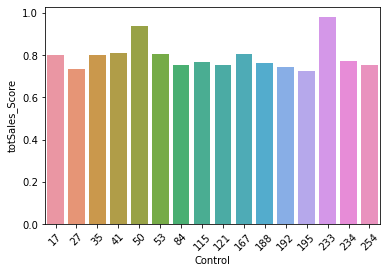

In [14]:
def CorrelPlot(df, ID, metric):
    Store77 = df[(df['Trial'] == ID) & (df['Control'] != ID)]
    Store77 = Store77.sort_values(by = metric, ascending = False).reset_index(drop = True)

    Store77 = Store77.loc[0:15]

    sns.barplot(x = 'Control', y = metric, data = Store77)
    plt.xticks(rotation = 45);
    plt.show()
CorrelPlot(totSalesCorrTable, 77, 'totSales_Score')

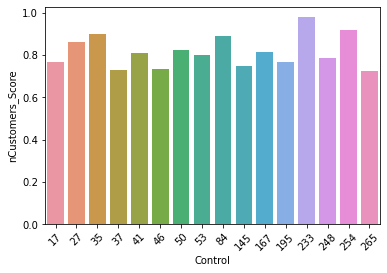

In [15]:
CorrelPlot(nCustomersCorrTable, 77, 'nCustomers_Score')

### Visualisations. <a class="anchor" id="sec_4.4"></a>
This is where I filter out the trial stores themselves out of the results as they are perfectly correlated with each other, aka a score of 1. Then, I sort the values to find the highest score in regards to each of the three trial stores.

In [16]:
Trial_Score = nCustomersCorrTable[['Trial', 'Control']].reset_index(drop = True)
Trial_Score['Score'] = nCustomersCorrTable['nCustomers_Score']*(weight) + totSalesCorrTable['totSales_Score']*(1 - weight)
Trial_Score.drop(Trial_Score[Trial_Score.Score == 1].index, inplace = True)

New_Controls = Trial_Score.sort_values('Score', ascending=False).drop_duplicates(['Trial']).reset_index(drop = True)
New_Controls

,Trial,Control,Score
0,77,233,0.979385
1,86,155,0.909400
2,88,237,0.748747


In [17]:
# Generating the names of the months for plotting purposes.
preTrialMeasures['MONTH'] = preTrialMeasures['YEARMONTH'].apply(lambda x: x + '01')
preTrialMeasures['MONTH'] = preTrialMeasures['MONTH'].apply(lambda x: dt.strptime(x, '%Y%m%d'))
preTrialMeasures['MONTH'] = preTrialMeasures['MONTH'].apply(lambda x: dt.strftime(x, '%B'))
preTrialMeasures

C:\Users\HP-user\AppData\Local\Temp\ipykernel_8972\1896002464.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preTrialMeasures['MONTH'] = preTrialMeasures['YEARMONTH'].apply(lambda x: x + '01')
C:\Users\HP-user\AppData\Local\Temp\ipykernel_8972\1896002464.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preTrialMeasures['MONTH'] = preTrialMeasures['MONTH'].apply(lambda x: dt.strptime(x, '%Y%m%d'))
C:\Users\HP-user\AppData\Local\Temp\ipykernel_8972\1896002464.py:4: SettingWithCopyWarning: 
A value is 

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,MONTH
0,1,201807,188.9,47,1.042553,1.183673,3.256897,July
1,1,201808,168.4,41,1.000000,1.268293,3.238462,August
2,1,201809,268.1,57,1.035088,1.203390,3.776056,September
3,1,201810,175.4,39,1.025641,1.275000,3.439216,October
4,1,201811,184.8,44,1.022727,1.222222,3.360000,November
...,...,...,...,...,...,...,...,...
3155,272,201809,294.5,31,1.129032,1.971429,4.268116,September
3156,272,201810,405.1,41,1.146341,2.000000,4.309574,October
3157,272,201811,355.8,39,1.102564,1.930233,4.286747,November
3158,272,201812,363.1,43,1.000000,1.883721,4.482716,December


In [18]:
print(' '*8 + 'Data Types')
print('-'*26)
print(preTrialMeasures.dtypes)

        Data Types
--------------------------
STORE_NBR            int64
YEARMONTH           object
totSales           float64
nCustomers           int64
nTxnPerCust        float64
nChipsPerTxn       float64
avgPricePerUnit    float64
MONTH               object
dtype: object


# 

C:\Users\HP-user\AppData\Local\Temp\ipykernel_8972\2461422838.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preTrialMeasures['Type'] = preTrialMeasures['STORE_NBR'].apply(lambda x: 'Trial' if (x == Trial) else \


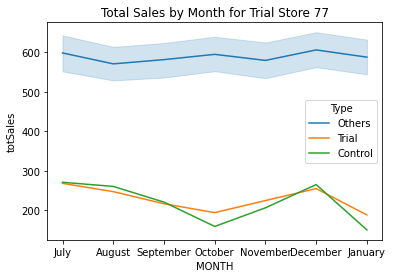

None

In [19]:
display(performancePlots(preTrialMeasures, 'totSales', 77, 233))

C:\Users\HP-user\AppData\Local\Temp\ipykernel_8972\2461422838.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preTrialMeasures['Type'] = preTrialMeasures['STORE_NBR'].apply(lambda x: 'Trial' if (x == Trial) else \


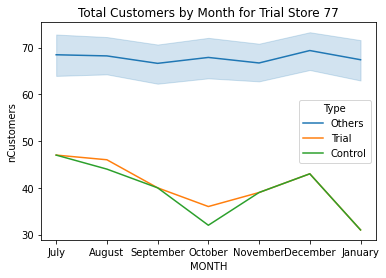

None

In [20]:
display(performancePlots(preTrialMeasures, 'nCustomers', 77, 233))

# Trial Assessments. <a class="anchor" id="sec_5"></a>
This is where I assess the control stores' performance against the trial stores.

## Trial Store 77. <a class="anchor" id="sec_5.1"></a>

### Total Sales. <a class="anchor" id="sec_5.1.1"></a>

In [21]:
# Defining the stores, and the metrics to use.
control_store = New_Controls['Control'].loc[0]
trial_store = New_Controls['Trial'].loc[0]
metricCol = 'totSales'

preTrialTrialSales = preTrialMeasures[metricCol][(preTrialMeasures['STORE_NBR']==
                                                  trial_store)].values
preTrialControlSales = preTrialMeasures[metricCol][(preTrialMeasures['STORE_NBR']==
                                                    control_store)].values

# Calculating the value to scale the control store's sales by, to account for any differences between
# the two stores outside of the trial period.
scalingFactorForControlSales = sum(preTrialTrialSales) / sum(preTrialControlSales)

# Retrieving the information pertaining to the control store.
PercentageDiff = measureOverTime[['YEARMONTH', metricCol]][measureOverTime['STORE_NBR']==
                                                            control_store].reset_index(drop = True)

# Applying the scaling factor to its sales.
PercentageDiff['controlSales'] = PercentageDiff[metricCol]*scalingFactorForControlSales

# Dropping the store's original total sales.
PercentageDiff.drop(columns = metricCol, inplace = True)
PercentageDiff

,YEARMONTH,controlSales
0,201807,281.980841
1,201808,271.063441
2,201809,229.681297
3,201810,165.632551
4,201811,214.708863
5,201812,275.950277
6,201901,156.482731
7,201902,229.473346
8,201903,187.779277
9,201904,149.932291


In [22]:
# Appending the trial stores' total sales values to the above dataframe.
PercentageDiff['trialSales'] = measureOverTime[metricCol][measureOverTime['STORE_NBR']==trial_store]\
                            .reset_index(drop = True)

# Finding the percentage difference between the trial and control store sales.
PercentageDiff['Diff (%)'] = abs(PercentageDiff['controlSales'] - PercentageDiff['trialSales'])\
                            /PercentageDiff['controlSales']
PercentageDiff

,YEARMONTH,controlSales,trialSales,Diff (%)
0,201807,281.980841,268.4,0.048162
1,201808,271.063441,247.5,0.086930
2,201809,229.681297,216.8,0.056083
3,201810,165.632551,194.3,0.173079
4,201811,214.708863,224.9,0.047465
5,201812,275.950277,255.2,0.075196
6,201901,156.482731,188.4,0.203967
7,201902,229.473346,211.6,0.077889
8,201903,187.779277,255.1,0.358510
9,201904,149.932291,258.1,0.721444


In [23]:
# Calculating the standard deviation of the percentage difference for t-test purposes.
preTrialStdDiff = st.stdev(PercentageDiff['Diff (%)'][PercentageDiff['YEARMONTH'] < '201902'].values)

# Filtering the time period to during the trial.
PercentageDiff = PercentageDiff[(PercentageDiff['YEARMONTH'] >= '201902') &\
                                (PercentageDiff['YEARMONTH'] < '201905')].reset_index(drop = True)

# Calculating the t-value for each YEARMONTH.
PercentageDiff['t-Value'] = (PercentageDiff['Diff (%)'] - 0)/preTrialStdDiff
PercentageDiff

,YEARMONTH,controlSales,trialSales,Diff (%),t-Value
0,201902,229.473346,211.6,0.077889,1.223912
1,201903,187.779277,255.1,0.358510,5.633494
2,201904,149.932291,258.1,0.721444,11.336505


### Discussion.
It's evident that the t-value is much larger during the period of March to April. This suggests that the increase in sales in the trial store is statistically greater than the sales in the control store.

In [24]:
# Identifying the critical t-value.
p_critical = t(df = 7).ppf(0.95)
p_critical

1.894578605061305

C:\Users\HP-user\AppData\Local\Temp\ipykernel_8972\2461422838.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preTrialMeasures['Type'] = preTrialMeasures['STORE_NBR'].apply(lambda x: 'Trial' if (x == Trial) else \


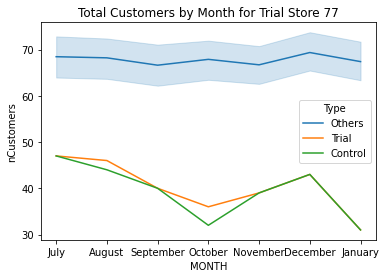

In [25]:
performancePlots(preTrialMeasures, 'nCustomers', trial_store, control_store)

In [26]:
# Extracting the information pertaining to Store 77's control store, Store 233.
pastSales = measureOverTime[measureOverTime['STORE_NBR'].isin([trial_store, control_store])]\
        .reset_index(drop = True)
pastSales['Type'] = 'Trial'
pastSales.loc[pastSales['STORE_NBR']==233, 'Type'] = 'Control'

pastSales.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Type
0,77,201807,268.4,47,1.085106,1.509804,3.485714,Trial
1,77,201808,247.5,46,1.000000,1.543478,3.485915,Trial
2,77,201809,216.8,40,1.050000,1.571429,3.284848,Trial
3,77,201810,194.3,36,1.027778,1.351351,3.886000,Trial
4,77,201811,224.9,39,1.076923,1.500000,3.569841,Trial


In [27]:
# Extracting the information pertaining to Store 77's control store, Store 233.
pastSales_Control5 = pastSales[pastSales['STORE_NBR']==control_store].reset_index(drop = True)

# Calculating the 5th percentile of the total sales.
pastSales_Control5['totSales'] = pastSales_Control5[metricCol].apply(lambda x: x * (1 - 
                                                                                     preTrialStdDiff *
                                                                                     2))

# Creating a type column for visualisation purposes.
pastSales_Control5['Type'] = 'Control 5th % confidence'
pastSales_Control5.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Type
0,233,201807,236.682213,47,1.042553,1.612245,3.432911,Control 5th % confidence
1,233,201808,227.518631,44,1.022727,1.600000,3.620833,Control 5th % confidence
2,233,201809,192.784295,40,1.075000,1.581395,3.248529,Control 5th % confidence
3,233,201810,139.024618,32,1.000000,1.500000,3.318750,Control 5th % confidence
4,233,201811,180.217098,39,1.025641,1.525000,3.385246,Control 5th % confidence


In [28]:
# Extracting the information pertaining to Store 77's control store, Store 233.
pastSales_Control95 = pastSales[pastSales['STORE_NBR']==control_store].reset_index(drop = True)

# Calculating the 95th percentile of the total sales.
pastSales_Control95['totSales'] = pastSales_Control95[metricCol].apply(lambda x: x *\
                                                                        (1 + preTrialStdDiff * 2))

# Creating a type column for visualisation purposes.
pastSales_Control95['Type'] = 'Control 95th % confidence'
pastSales_Control95.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Type
0,233,201807,305.717787,47,1.042553,1.612245,3.432911,Control 95th % confidence
1,233,201808,293.881369,44,1.022727,1.600000,3.620833,Control 95th % confidence
2,233,201809,249.015705,40,1.075000,1.581395,3.248529,Control 95th % confidence
3,233,201810,179.575382,32,1.000000,1.500000,3.318750,Control 95th % confidence
4,233,201811,232.782902,39,1.025641,1.525000,3.385246,Control 95th % confidence


In [29]:
# Concatenating all the three dataframes together.
trialAssessment = pd.concat([pastSales, pastSales_Control5, pastSales_Control95]).reset_index(drop =
                                                                                              True)

# Some modifications to the MONTH column for visualisation purposes.
trialAssessment['MONTH'] = trialAssessment['YEARMONTH'].apply(lambda x: x + '01')
trialAssessment['MONTH'] = trialAssessment['MONTH'].apply(lambda x: dt.strptime(x, '%Y%m%d'))
trialAssessment['MONTH'] = trialAssessment['MONTH'].apply(lambda x: dt.strftime(x, '%B'))
trialAssessment.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Type,MONTH
0,77,201807,268.4,47,1.085106,1.509804,3.485714,Trial,July
1,77,201808,247.5,46,1.000000,1.543478,3.485915,Trial,August
2,77,201809,216.8,40,1.050000,1.571429,3.284848,Trial,September
3,77,201810,194.3,36,1.027778,1.351351,3.886000,Trial,October
4,77,201811,224.9,39,1.076923,1.500000,3.569841,Trial,November


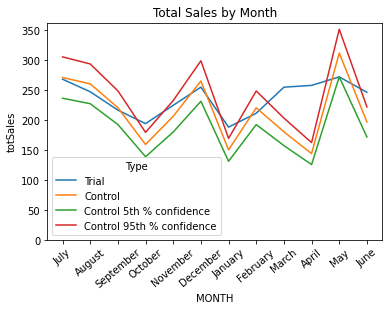

In [30]:
# Visualisation.
sns.lineplot(x = 'MONTH', y = 'totSales', hue = 'Type', data = trialAssessment)\
.set(title = 'Total Sales by Month')
plt.ylim(ymin = 0)
plt.xticks(rotation = 40);

### Discussion.
Since the total sales increased during the trial period, it suggests that the trial had a positive effect. This is also because the values during the trial period lie outside of the 5th and 95th confidence intervals.

### Number of Customers. <a class="anchor" id="sec_5.1.2"></a>
The code below is identical to the ones above, but performed on the total customers instead of the total sales.

In [31]:
# Defining the stores, and the metrics to use.
control_store = New_Controls['Control'].loc[0]
trial_store = New_Controls['Trial'].loc[0]
metricCol = 'nCustomers'

# Retrieving the values of the trial and the control stores.
preTrialTrialCustomers = preTrialMeasures[metricCol][(preTrialMeasures['STORE_NBR']==
                                                      trial_store)].values
preTrialControlCustomers = preTrialMeasures[metricCol][(preTrialMeasures['STORE_NBR']==
                                                        control_store)].values

# Calculating the value to scale the control store's sales by, to account for any differences between
# the two stores outside of the trial period.
scalingFactorForControlCustomers = sum(preTrialTrialCustomers) / sum(preTrialControlCustomers)

# Retrieving the information pertaining to the control store.
PercentageDiff = measureOverTime[['YEARMONTH', metricCol]][measureOverTime['STORE_NBR']==
                                                            control_store].reset_index(drop = True)

# Applying the scaling factor to its sales.
PercentageDiff['ctrlCustomers'] = PercentageDiff[metricCol]*scalingFactorForControlCustomers

# Dropping the store's original total sales.
PercentageDiff.drop(columns = metricCol, inplace = True)




# Appending the trial stores' total sales values to the above dataframe.
PercentageDiff['trialCustomers'] = measureOverTime[metricCol][measureOverTime['STORE_NBR']==
                                                              trial_store].reset_index(drop = True)

# Finding the percentage difference between the trial and control store sales.
PercentageDiff['Diff (%)'] = abs(PercentageDiff['ctrlCustomers'] - PercentageDiff['trialCustomers'])\
                            /PercentageDiff['ctrlCustomers']




# Calculating the standard deviation of the percentage difference for t-test purposes.
preTrialStdDiff = st.stdev(PercentageDiff['Diff (%)'][PercentageDiff['YEARMONTH'] < '201902'].values)

# Filtering the time period to during the trial.
PercentageDiff = PercentageDiff[(PercentageDiff['YEARMONTH'] >= '201902') &
                                (PercentageDiff['YEARMONTH'] < '201905')].reset_index(drop = True)

# Calculating the t-value for each YEARMONTH.
PercentageDiff['t-Value'] = (PercentageDiff['Diff (%)'] - 0)/preTrialStdDiff
PercentageDiff

,YEARMONTH,ctrlCustomers,trialCustomers,Diff (%),t-Value
0,201902,42.913043,40,0.067882,2.259470
1,201903,35.760870,46,0.286322,9.530240
2,201904,27.586957,47,0.703704,23.422793


In [32]:
# Extracting the information pertaining to Store 77's control store, Store 233.
pastCustomers = measureOverTime[measureOverTime['STORE_NBR'].isin([trial_store, control_store])]\
        .reset_index(drop = True)
pastCustomers['Type'] = 'Trial'
pastCustomers.loc[pastCustomers['STORE_NBR']==control_store, 'Type'] = 'Control'




# Extracting the information pertaining to Store 77's control store, Store 233.
pastCustomers_Control5 = pastSales[pastSales['STORE_NBR']==control_store].reset_index(drop = True)

# Calculating the 5th percentile of the total sales.
pastCustomers_Control5[metricCol] = pastSales_Control5[metricCol].apply(lambda x: x * (1 - 
                                                                                     preTrialStdDiff *
                                                                                     2))

# Creating a type column for visualisation purposes.
pastCustomers_Control5['Type'] = 'Control 5th % confidence'




# Extracting the information pertaining to Store 77's control store, Store 233.
pastCustomers_Control95 = pastSales[pastSales['STORE_NBR']==control_store].reset_index(drop = True)

# Calculating the 95th percentile of the total sales.
pastCustomers_Control95[metricCol] = pastSales_Control95[metricCol].apply(lambda x: x *\
                                                                        (1 + preTrialStdDiff * 2))

# Creating a type column for visualisation purposes.
pastCustomers_Control95['Type'] = 'Control 95th % confidence'




# Concatenating all the three dataframes together.
trialAssessment_77 = pd.concat([pastCustomers, pastCustomers_Control5, pastCustomers_Control95]).reset_index(drop =
                                                                                              True)

# Some modifications to the MONTH column for visualisation purposes.
trialAssessment_77['MONTH'] = trialAssessment_77['YEARMONTH'].apply(lambda x: x + '01')
trialAssessment_77['MONTH'] = trialAssessment_77['MONTH'].apply(lambda x: dt.strptime(x, '%Y%m%d'))
trialAssessment_77['MONTH'] = trialAssessment_77['MONTH'].apply(lambda x: dt.strftime(x, '%B'))
trialAssessment_77.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Type,MONTH
0,77,201807,268.4,47.0,1.085106,1.509804,3.485714,Trial,July
1,77,201808,247.5,46.0,1.000000,1.543478,3.485915,Trial,August
2,77,201809,216.8,40.0,1.050000,1.571429,3.284848,Trial,September
3,77,201810,194.3,36.0,1.027778,1.351351,3.886000,Trial,October
4,77,201811,224.9,39.0,1.076923,1.500000,3.569841,Trial,November


### Discussion.
Since the total number of customers increased during the trial period, it suggests that the trial had a positive effect. This is also because the values during the trial period lie outside of the 5th and 95th confidence intervals.

## Trial Store 86. <a class="anchor" id="sec_5.2"></a>
The same two comparisons are done once again, but for Store 86 and its' control store, Store 155.

### Total Sales. <a class="anchor" id="sec_5.2.1"></a>

In [33]:
# Defining the stores, and the metrics to use.
control_store = New_Controls['Control'].loc[1]
trial_store = New_Controls['Trial'].loc[1]
metricCol = 'totSales'

preTrialTrialSales = preTrialMeasures[metricCol][(preTrialMeasures['STORE_NBR']==
                                                  trial_store)].values
preTrialControlSales = preTrialMeasures[metricCol][(preTrialMeasures['STORE_NBR']==
                                                    control_store)].values

# Calculating the value to scale the control store's sales by, to account for any differences between
# the two stores outside of the trial period.
scalingFactorForControlSales = sum(preTrialTrialSales) / sum(preTrialControlSales)

# Retrieving the information pertaining to the control store.
PercentageDiff = measureOverTime[['YEARMONTH', metricCol]][measureOverTime['STORE_NBR']==
                                                            control_store].reset_index(drop = True)

# Applying the scaling factor to its sales.
PercentageDiff['controlSales'] = PercentageDiff[metricCol]*scalingFactorForControlSales

# Dropping the store's original total sales.
PercentageDiff.drop(columns = metricCol, inplace = True)




# Appending the trial stores' total sales values to the above dataframe.
PercentageDiff['trialSales'] = measureOverTime[metricCol][measureOverTime['STORE_NBR']==trial_store]\
                            .reset_index(drop = True)

# Finding the percentage difference between the trial and control store sales.
PercentageDiff['Diff (%)'] = abs(PercentageDiff['controlSales'] - PercentageDiff['trialSales'])\
                            /PercentageDiff['controlSales']




# Calculating the standard deviation of the percentage difference for t-test purposes.
preTrialStdDiff = st.stdev(PercentageDiff['Diff (%)'][PercentageDiff['YEARMONTH'] < '201902'].values)

# Filtering the time period to during the trial.
PercentageDiff = PercentageDiff[(PercentageDiff['YEARMONTH'] >= '201902') &\
                                (PercentageDiff['YEARMONTH'] < '201905')].reset_index(drop = True)

# Calculating the t-value for each YEARMONTH.
PercentageDiff['t-Value'] = (PercentageDiff['Diff (%)'] - 0)/preTrialStdDiff
PercentageDiff

,YEARMONTH,controlSales,trialSales,Diff (%),t-Value
0,201902,827.019610,872.8,0.055356,2.642804
1,201903,745.561872,945.4,0.268037,12.796638
2,201904,778.028321,804.0,0.033381,1.593697


C:\Users\HP-user\AppData\Local\Temp\ipykernel_8972\2461422838.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preTrialMeasures['Type'] = preTrialMeasures['STORE_NBR'].apply(lambda x: 'Trial' if (x == Trial) else \


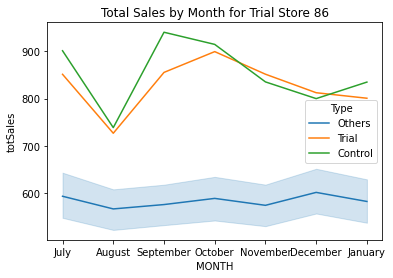

In [34]:
performancePlots(preTrialMeasures, 'totSales', trial_store, control_store)

In [35]:
# Extracting the information pertaining to Store 86's control store, Store 155.
pastSales = measureOverTime[measureOverTime['STORE_NBR'].isin([trial_store, control_store])]\
        .reset_index(drop = True)
pastSales['Type'] = 'Trial'
pastSales.loc[pastSales['STORE_NBR']==control_store, 'Type'] = 'Control'




# Extracting the information pertaining to Store 86's control store, Store 155.
pastSales_Control5 = pastSales[pastSales['STORE_NBR']==control_store].reset_index(drop = True)

# Calculating the 5th percentile of the total sales.
pastSales_Control5['totSales'] = pastSales_Control5[metricCol].apply(lambda x: x * (1 - 
                                                                                     preTrialStdDiff *
                                                                                     2))

# Creating a type column for visualisation purposes.
pastSales_Control5['Type'] = 'Control 5th % confidence'
pastSales_Control5.head()




# Extracting the information pertaining to Store 86's control store, Store 155.
pastSales_Control95 = pastSales[pastSales['STORE_NBR']==control_store].reset_index(drop = True)

# Calculating the 95th percentile of the total sales.
pastSales_Control95['totSales'] = pastSales_Control95[metricCol].apply(lambda x: x *\
                                                                        (1 + preTrialStdDiff * 2))

# Creating a type column for visualisation purposes.
pastSales_Control95['Type'] = 'Control 95th % confidence'
pastSales_Control95.head()




# Concatenating all the three dataframes together.
trialAssessment_86 = pd.concat([pastSales,
                                pastSales_Control5,
                                pastSales_Control95]).reset_index(drop = True)

# Some modifications to the MONTH column for visualisation purposes.
trialAssessment_86['MONTH'] = trialAssessment_86['YEARMONTH'].apply(lambda x: x + '01')
trialAssessment_86['MONTH'] = trialAssessment_86['MONTH'].apply(lambda x: dt.strptime(x, '%Y%m%d'))
trialAssessment_86['MONTH'] = trialAssessment_86['MONTH'].apply(lambda x: dt.strftime(x, '%B'))
trialAssessment_86.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Type,MONTH
0,86,201807,851.00,94,1.276596,1.991667,3.560669,Trial,July
1,86,201808,726.85,92,1.130435,1.951923,3.580542,Trial,August
2,86,201809,855.00,100,1.200000,2.016667,3.533058,Trial,September
3,86,201810,898.80,105,1.238095,2.000000,3.456923,Trial,October
4,86,201811,851.20,95,1.242105,2.016949,3.576471,Trial,November


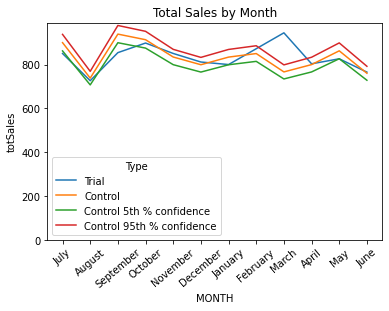

In [36]:
# Visualisation.
sns.lineplot(x = 'MONTH', y = 'totSales', hue = 'Type', data = trialAssessment_86)\
.set(title = 'Total Sales by Month')
plt.ylim(ymin = 0)
plt.xticks(rotation = 40);

### Discussion.
Since the total sales increased during the trial period, it suggests that the trial had a positive effect. This is also because the values during the trial period lie outside of the 5th and 95th confidence intervals.

### Number of Customers. <a class="anchor" id="sec_5.2.2"></a>

In [37]:
# Defining the stores, and the metrics to use.
control_store = New_Controls['Control'].loc[1]
trial_store = New_Controls['Trial'].loc[1]
metricCol = 'nCustomers'

# Retrieving the values of the trial and the control stores.
preTrialTrialCustomers = preTrialMeasures[metricCol][(preTrialMeasures['STORE_NBR']==trial_store)]\
                        .values
preTrialControlCustomers = preTrialMeasures[metricCol][(preTrialMeasures['STORE_NBR']==control_store)]\
                        .values

# Calculating the value to scale the control store's sales by, to account for any differences between
# the two stores outside of the trial period.
scalingFactorForControlCustomers = sum(preTrialTrialCustomers) / sum(preTrialControlCustomers)

# Retrieving the information pertaining to the control store.
PercentageDiff = measureOverTime[['YEARMONTH', metricCol]][measureOverTime['STORE_NBR']==
                                                            control_store].reset_index(drop = True)

# Applying the scaling factor to its sales.
PercentageDiff['ctrlCustomers'] = PercentageDiff[metricCol]*scalingFactorForControlCustomers

# Dropping the store's original total sales.
PercentageDiff.drop(columns = metricCol, inplace = True)




# Appending the trial stores' total sales values to the above dataframe.
PercentageDiff['trialCustomers'] = measureOverTime[metricCol][measureOverTime['STORE_NBR']==
                                                              trial_store].reset_index(drop = True)

# Finding the percentage difference between the trial and control store sales.
PercentageDiff['Diff (%)'] = abs(PercentageDiff['ctrlCustomers'] - PercentageDiff['trialCustomers'])\
                            /PercentageDiff['ctrlCustomers']




# Calculating the standard deviation of the percentage difference for t-test purposes.
preTrialStdDiff = st.stdev(PercentageDiff['Diff (%)'][PercentageDiff['YEARMONTH'] < '201902'].values)

# Filtering the time period to during the trial.
PercentageDiff = PercentageDiff[(PercentageDiff['YEARMONTH'] >= '201902') &
                                (PercentageDiff['YEARMONTH'] < '201905')].reset_index(drop = True)

# Calculating the t-value for each YEARMONTH.
PercentageDiff['t-Value'] = (PercentageDiff['Diff (%)'] - 0)/preTrialStdDiff
PercentageDiff

,YEARMONTH,ctrlCustomers,trialCustomers,Diff (%),t-Value
0,201902,92.276276,105,0.137887,8.605720
1,201903,91.273273,108,0.183260,11.437481
2,201904,93.279279,99,0.061329,3.827618


C:\Users\HP-user\AppData\Local\Temp\ipykernel_8972\2461422838.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preTrialMeasures['Type'] = preTrialMeasures['STORE_NBR'].apply(lambda x: 'Trial' if (x == Trial) else \


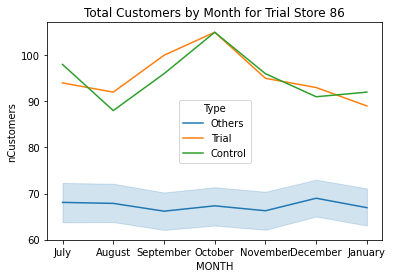

In [38]:
performancePlots(preTrialMeasures, 'nCustomers', trial_store, control_store)

In [39]:
# Extracting the information pertaining to Store 88's control store, Store 178.
pastCustomers = measureOverTime[measureOverTime['STORE_NBR'].isin([trial_store, control_store])]\
        .reset_index(drop = True)
pastCustomers['Type'] = 'Trial'
pastCustomers.loc[pastCustomers['STORE_NBR']==control_store, 'Type'] = 'Control'




# Extracting the information pertaining to Store 88's control store, Store 178.
pastCustomers_Control5 = pastSales[pastSales['STORE_NBR']==control_store].reset_index(drop = True)

# Calculating the 5th percentile of the total sales.
pastCustomers_Control5[metricCol] = pastSales_Control5[metricCol].apply(lambda x: x * (1 - 
                                                                                     preTrialStdDiff *
                                                                                     2))

# Creating a type column for visualisation purposes.
pastCustomers_Control5['Type'] = 'Control 5th % confidence'




# Extracting the information pertaining to Store 88's control store, Store 178.
pastCustomers_Control95 = pastSales[pastSales['STORE_NBR']==control_store].reset_index(drop = True)

# Calculating the 95th percentile of the total sales.
pastCustomers_Control95[metricCol] = pastSales_Control95[metricCol].apply(lambda x: x *\
                                                                        (1 + preTrialStdDiff * 2))

# Creating a type column for visualisation purposes.
pastCustomers_Control95['Type'] = 'Control 95th % confidence'




# Concatenating all the three dataframes together.
trialAssessment_86 = pd.concat([pastCustomers,
                                pastCustomers_Control5,
                                pastCustomers_Control95]).reset_index(drop = True)

# Some modifications to the MONTH column for visualisation purposes.
trialAssessment_86['MONTH'] = trialAssessment_86['YEARMONTH'].apply(lambda x: x + '01')
trialAssessment_86['MONTH'] = trialAssessment_86['MONTH'].apply(lambda x: dt.strptime(x, '%Y%m%d'))
trialAssessment_86['MONTH'] = trialAssessment_86['MONTH'].apply(lambda x: dt.strftime(x, '%B'))
trialAssessment_86.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Type,MONTH
0,86,201807,851.00,94.0,1.276596,1.991667,3.560669,Trial,July
1,86,201808,726.85,92.0,1.130435,1.951923,3.580542,Trial,August
2,86,201809,855.00,100.0,1.200000,2.016667,3.533058,Trial,September
3,86,201810,898.80,105.0,1.238095,2.000000,3.456923,Trial,October
4,86,201811,851.20,95.0,1.242105,2.016949,3.576471,Trial,November


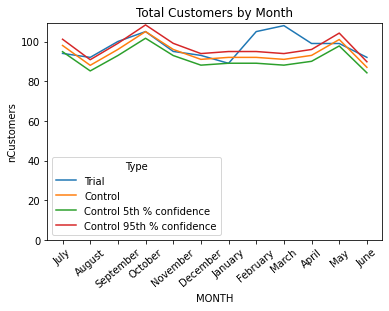

In [40]:
# Visualisation.
sns.lineplot(x = 'MONTH', y = 'nCustomers', hue = 'Type', data = trialAssessment_86)\
.set(title = 'Total Customers by Month')
plt.ylim(ymin = 0)
plt.xticks(rotation = 40);

### Discussion.
Since the total number of customers increased during the trial period, it suggests that the trial had a positive effect. This is also because the values during the trial period lie outside of the 5th and 95th confidence intervals.

## Trial Store 88 <a class="anchor" id="sec_5.3"></a>

### Total Sales. <a class="anchor" id="sec_5.3.1"></a>

In [41]:
# Defining the stores, and the metrics to use.
control_store = New_Controls['Control'].loc[2]
trial_store = New_Controls['Trial'].loc[2]
metricCol = 'totSales'

preTrialTrialSales = preTrialMeasures[metricCol][(preTrialMeasures['STORE_NBR']==trial_store)].values
preTrialControlSales = preTrialMeasures[metricCol][(preTrialMeasures['STORE_NBR']==control_store)].values

# Calculating the value to scale the control store's sales by, to account for any differences between
# the two stores outside of the trial period.
scalingFactorForControlSales = sum(preTrialTrialSales) / sum(preTrialControlSales)

# Retrieving the information pertaining to the control store.
PercentageDiff = measureOverTime[['YEARMONTH', metricCol]][measureOverTime['STORE_NBR']==
                                                            control_store].reset_index(drop = True)

# Applying the scaling factor to its sales.
PercentageDiff['controlSales'] = PercentageDiff[metricCol]*scalingFactorForControlSales

# Dropping the store's original total sales.
PercentageDiff.drop(columns = metricCol, inplace = True)




# Appending the trial stores' total sales values to the above dataframe.
PercentageDiff['trialSales'] = measureOverTime[metricCol][measureOverTime['STORE_NBR']==trial_store]\
                            .reset_index(drop = True)

# Finding the percentage difference between the trial and control store sales.
PercentageDiff['Diff (%)'] = abs(PercentageDiff['controlSales'] - PercentageDiff['trialSales'])\
                            /PercentageDiff['controlSales']




# Calculating the standard deviation of the percentage difference for t-test purposes.
preTrialStdDiff = st.stdev(PercentageDiff['Diff (%)'][PercentageDiff['YEARMONTH'] < '201902'].values)

# Filtering the time period to during the trial.
PercentageDiff = PercentageDiff[(PercentageDiff['YEARMONTH'] >= '201902') &\
                                (PercentageDiff['YEARMONTH'] < '201905')].reset_index(drop = True)

# Calculating the t-value for each YEARMONTH.
PercentageDiff['t-Value'] = (PercentageDiff['Diff (%)'] - 0)/preTrialStdDiff
PercentageDiff

,YEARMONTH,controlSales,trialSales,Diff (%),t-Value
0,201902,1300.879003,1339.6,0.029765,0.606487
1,201903,1166.728952,1467.0,0.257361,5.243910
2,201904,1142.950509,1317.0,0.152281,3.102824


C:\Users\HP-user\AppData\Local\Temp\ipykernel_8972\2461422838.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preTrialMeasures['Type'] = preTrialMeasures['STORE_NBR'].apply(lambda x: 'Trial' if (x == Trial) else \


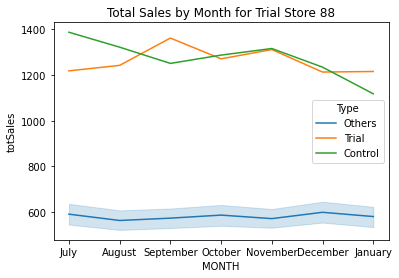

In [42]:
performancePlots(preTrialMeasures, 'totSales', trial_store, control_store)

In [43]:
# Extracting the information pertaining to Store 88's control store, Store 178.
pastSales = measureOverTime[measureOverTime['STORE_NBR'].isin([trial_store, control_store])]\
        .reset_index(drop = True)
pastSales['StoreType'] = 'Trial'
pastSales.loc[pastSales['STORE_NBR']==control_store, 'StoreType'] = 'Control'




# Extracting the information pertaining to Store 88's control store, Store 178.
pastSales_Control5 = pastSales[pastSales['STORE_NBR']==control_store].reset_index(drop = True)

# Calculating the 5th percentile of the total sales.
pastSales_Control5['totSales'] = pastSales_Control5[metricCol].apply(lambda x: x * (1 - 
                                                                                     preTrialStdDiff *
                                                                                     2))

# Creating a type column for visualisation purposes.
pastSales_Control5['StoreType'] = 'Control 5th % confidence'
pastSales_Control5.head()




# Extracting the information pertaining to Store 88's control store, Store 178.
pastSales_Control95 = pastSales[pastSales['STORE_NBR']==control_store].reset_index(drop = True)

# Calculating the 95th percentile of the total sales.
pastSales_Control95['totSales'] = pastSales_Control95[metricCol].apply(lambda x: x *\
                                                                        (1 + preTrialStdDiff * 2))

# Creating a type column for visualisation purposes.
pastSales_Control95['StoreType'] = 'Control 95th % confidence'
pastSales_Control95.head()




# Concatenating all the three dataframes together.
trialAssessment_88 = pd.concat([pastSales,
                                pastSales_Control5,
                                pastSales_Control95]).reset_index(drop = True)

# Some modifications to the MONTH column for visualisation purposes.
trialAssessment_88['MONTH'] = trialAssessment_88['YEARMONTH'].apply(lambda x: x + '01')
trialAssessment_88['MONTH'] = trialAssessment_88['MONTH'].apply(lambda x: dt.strptime(x, '%Y%m%d'))
trialAssessment_88['MONTH'] = trialAssessment_88['MONTH'].apply(lambda x: dt.strftime(x, '%B'))
trialAssessment_88

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,StoreType,MONTH
0,88,201807,1218.200000,124,1.161290,2.000000,4.229861,Trial,July
1,88,201808,1242.200000,125,1.200000,1.913333,4.328223,Trial,August
2,88,201809,1361.800000,121,1.247934,2.026490,4.450327,Trial,September
3,88,201810,1270.800000,120,1.225000,2.040816,4.236000,Trial,October
4,88,201811,1311.400000,123,1.211382,2.013423,4.371333,Trial,November
5,88,201812,1213.000000,120,1.141667,2.014599,4.394928,Trial,December
6,88,201901,1215.400000,115,1.217391,2.014286,4.309929,Trial,January
7,88,201902,1339.600000,122,1.229508,2.013333,4.435762,Trial,February
8,88,201903,1467.000000,133,1.263158,2.011905,4.340237,Trial,March
9,88,201904,1317.000000,119,1.260504,2.000000,4.390000,Trial,April


<BarContainer object of 3 artists>

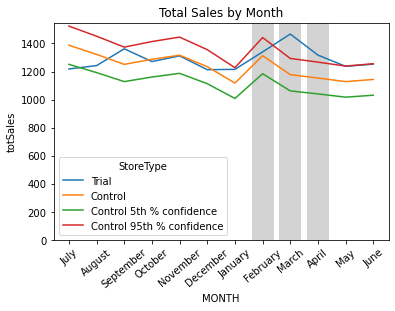

In [44]:
# Visualisation.
sns.lineplot(x = 'MONTH', y = 'totSales', hue = 'StoreType', data = trialAssessment_88)\
.set(title = 'Total Sales by Month')
plt.ylim(ymin = 0)
plt.xticks(rotation = 40);
plt.bar(x = ['February', 'March', 'April'], height = 2000, color = 'lightgrey')

### Discussion.
Since the total sales increased during the trial period, it suggests that the trial had a positive effect. This is also because the values during the trial period lie outside of the 5th and 95th confidence intervals.

### Number of Customers. <a class="anchor" id="sec_5.3.2"></a>

In [45]:
# Defining the stores, and the metrics to use.
control_store = New_Controls['Control'].loc[2]
trial_store = New_Controls['Trial'].loc[2]
metricCol = 'nCustomers'

# Retrieving the values of the trial and the control stores.
preTrialTrialCustomers = preTrialMeasures[metricCol][(preTrialMeasures['STORE_NBR']==trial_store)]\
                        .values
preTrialControlCustomers = preTrialMeasures[metricCol][(preTrialMeasures['STORE_NBR']==control_store)]\
                        .values

# Calculating the value to scale the control store's sales by, to account for any differences between
# the two stores outside of the trial period.
scalingFactorForControlCustomers = sum(preTrialTrialCustomers) / sum(preTrialControlCustomers)

# Retrieving the information pertaining to the control store.
PercentageDiff = measureOverTime[['YEARMONTH', metricCol]][measureOverTime['STORE_NBR']==
                                                            control_store].reset_index(drop = True)

# Applying the scaling factor to its sales.
PercentageDiff['ctrlCustomers'] = PercentageDiff[metricCol]*scalingFactorForControlCustomers

# Dropping the store's original total sales.
PercentageDiff.drop(columns = metricCol, inplace = True)




# Appending the trial stores' total sales values to the above dataframe.
PercentageDiff['trialCustomers'] = measureOverTime[metricCol][measureOverTime['STORE_NBR']==
                                                              trial_store].reset_index(drop = True)

# Finding the percentage difference between the trial and control store sales.
PercentageDiff['Diff (%)'] = abs(PercentageDiff['ctrlCustomers'] - PercentageDiff['trialCustomers'])\
                            /PercentageDiff['ctrlCustomers']




# Calculating the standard deviation of the percentage difference for t-test purposes.
preTrialStdDiff = st.stdev(PercentageDiff['Diff (%)'][PercentageDiff['YEARMONTH'] < '201902'].values)

# Filtering the time period to during the trial.
PercentageDiff = PercentageDiff[(PercentageDiff['YEARMONTH'] >= '201902') &
                                (PercentageDiff['YEARMONTH'] < '201905')].reset_index(drop = True)

# Calculating the t-value for each YEARMONTH.
PercentageDiff['t-Value'] = (PercentageDiff['Diff (%)'] - 0)/preTrialStdDiff
PercentageDiff

,YEARMONTH,ctrlCustomers,trialCustomers,Diff (%),t-Value
0,201902,118.441315,122,0.030046,1.677105
1,201903,115.455399,133,0.151960,8.482095
2,201904,115.455399,119,0.030701,1.713669


C:\Users\HP-user\AppData\Local\Temp\ipykernel_8972\2461422838.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preTrialMeasures['Type'] = preTrialMeasures['STORE_NBR'].apply(lambda x: 'Trial' if (x == Trial) else \


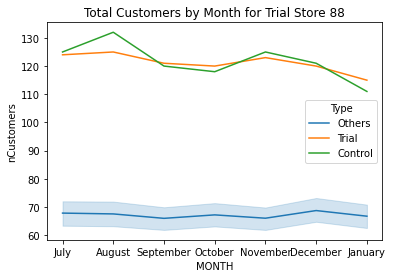

In [46]:
performancePlots(preTrialMeasures, 'nCustomers', trial_store, control_store)

In [47]:
# Extracting the information pertaining to Store 88's control store, Store 178.
pastCustomers = measureOverTime[measureOverTime['STORE_NBR'].isin([trial_store, control_store])]\
        .reset_index(drop = True)
pastCustomers['StoreType'] = 'Trial'
pastCustomers.loc[pastCustomers['STORE_NBR']==control_store, 'StoreType'] = 'Control'




# Extracting the information pertaining to Store 88's control store, Store 178.
pastCustomers_Control5 = pastSales[pastSales['STORE_NBR']==control_store].reset_index(drop = True)

# Calculating the 5th percentile of the total sales.
pastCustomers_Control5[metricCol] = pastSales_Control5[metricCol].apply(lambda x: x * (1 - 
                                                                                     preTrialStdDiff *
                                                                                     2))

# Creating a type column for visualisation purposes.
pastCustomers_Control5['StoreType'] = 'Control 5th % confidence'




# Extracting the information pertaining to Store 88's control store, Store 178.
pastCustomers_Control95 = pastSales[pastSales['STORE_NBR']==control_store].reset_index(drop = True)

# Calculating the 95th percentile of the total sales.
pastCustomers_Control95[metricCol] = pastSales_Control95[metricCol].apply(lambda x: x *\
                                                                        (1 + preTrialStdDiff * 2))

# Creating a type column for visualisation purposes.
pastCustomers_Control95['StoreType'] = 'Control 95th % confidence'




# Concatenating all the three dataframes together.
trialAssessment_88 = pd.concat([pastCustomers, pastCustomers_Control5, pastCustomers_Control95]).reset_index(drop =
                                                                                              True)

# Some modifications to the MONTH column for visualisation purposes.
trialAssessment_88['MONTH'] = trialAssessment_88['YEARMONTH'].apply(lambda x: x + '01')
trialAssessment_88['MONTH'] = trialAssessment_88['MONTH'].apply(lambda x: dt.strptime(x, '%Y%m%d'))
trialAssessment_88['MONTH'] = trialAssessment_88['MONTH'].apply(lambda x: dt.strftime(x, '%B'))
trialAssessment_88.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,StoreType,MONTH
0,88,201807,1218.2,124.0,1.161290,2.000000,4.229861,Trial,July
1,88,201808,1242.2,125.0,1.200000,1.913333,4.328223,Trial,August
2,88,201809,1361.8,121.0,1.247934,2.026490,4.450327,Trial,September
3,88,201810,1270.8,120.0,1.225000,2.040816,4.236000,Trial,October
4,88,201811,1311.4,123.0,1.211382,2.013423,4.371333,Trial,November


In [53]:
New_Controls

,Trial,Control,Score
0,77,233,0.979385
1,86,155,0.909400
2,88,237,0.748747


C:\Users\HP-user\AppData\Local\Temp\ipykernel_8972\2461422838.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preTrialMeasures['Type'] = preTrialMeasures['STORE_NBR'].apply(lambda x: 'Trial' if (x == Trial) else \


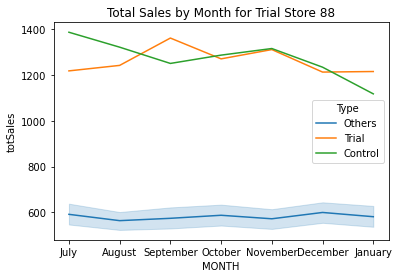

In [54]:
performancePlots(preTrialMeasures, 'totSales', 88, 237)

C:\Users\HP-user\AppData\Local\Temp\ipykernel_8972\2461422838.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preTrialMeasures['Type'] = preTrialMeasures['STORE_NBR'].apply(lambda x: 'Trial' if (x == Trial) else \


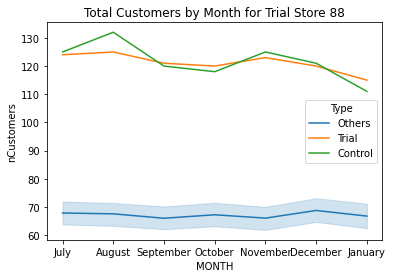

In [55]:
performancePlots(preTrialMeasures, 'nCustomers', 88, 237)

<BarContainer object of 3 artists>

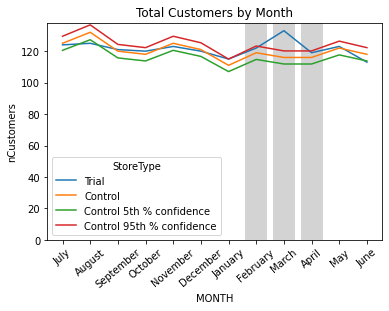

In [48]:
# Visualisation.
sns.lineplot(x = 'MONTH', y = 'nCustomers', hue = 'StoreType', data = trialAssessment_88)\
.set(title = 'Total Customers by Month')
plt.ylim(ymin = 0)
plt.xticks(rotation = 40);
plt.bar(x = ['February', 'March', 'April'], height = 1000, color = 'lightgrey')

<BarContainer object of 3 artists>

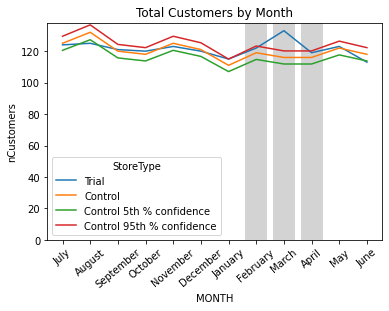

In [50]:
# Visualisation.
sns.lineplot(x = 'MONTH', y = 'nCustomers', hue = 'StoreType', data = trialAssessment_88)\
.set(title = 'Total Customers by Month')
plt.ylim(ymin = 0)
plt.xticks(rotation = 40);
plt.bar(x = ['February', 'March', 'April'], height = 2000, color = 'lightgrey')

### Discussion.
Since the total number of customers increased during the trial period, it suggests that the trial had a positive effect. This is also because the values during the trial period lie outside of the 5th and 95th confidence intervals.

## Conclusion. <a class="anchor" id="sec_6"></a>
Thanks to the analysis done in Task 2, I have identified stores 233, 155 and 178 to be control stores for stores 77, 86 and 88 respectively. The results during the trial period show a significant increase in the number of customers, and consequently, the number of sales for stores 77 and 86. However, this is not the same for store 88. It would be a good idea to check with the client to see if the implementation of the trial was different for store 88, but the overall trend shows that the trial had a positive effect on the number of sales.